In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns
import numpy as np

<h1> Overview </h1>

We will compare how hyperprior choice $\tau$ affects performance of the horseshoe prior by replicating an experiment done by Piironen and Vehtari in "Sparsity information and regularization in the horseshoe and other shrinkage priors".

<h1> Generating Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [2]:
# Parameters
n_realizations = 10
n = 400 # number of observations, length of beta_star 
D = n 
p_star = 20 # number of non-zero predictors
sigma = 1 # noise parameter

# Generate data
def get_data(A):
    beta_star = np.zeros(n)
    beta_star[range(20)] = A
    y = beta_star + np.random.normal(0, sigma, size=n)
    return y, beta_star

<h2> Defining the Model </h2>

Horseshoe prior:
$$ y_i \sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots,n$$ 
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ \lambda_i \sim C^+(0, 1)$$




We will compare two different hyperpriors for $\tau$: 

$\tau \sim C^+(0, 1)$ and $\tau = \tau_0 = \frac{p^*}{D-p^*}\sigma$.

In [3]:
def halfcauchy(all_data):
    def horseshoe_halfcauchy(y=None, sigma=1):
        '''
        Parameters:
        array y: dependent variable
        int sigma: stdev of y
        '''
        hc_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n)))
        hc_tau = numpyro.sample('tau', dist.HalfCauchy(1))
        
        # slightly different parametrization for efficiency
        hc_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(n)))
        hc_scaled_betas = numpyro.deterministic("betas", hc_tau*hc_lambdas*hc_unscaled_betas)

        hc_kappas = numpyro.deterministic("kappas", 1 / (1 + n * hc_tau**2 * hc_lambdas**2))
        numpyro.sample('y', dist.Normal(hc_scaled_betas, sigma), obs=y)

    def run_mcmc_halfcauchy(y):
        mcmc_halfcauchy = MCMC(
            NUTS(horseshoe_halfcauchy),
            num_warmup= 1000,
            num_samples= 1000)
        mcmc_halfcauchy.run(random.PRNGKey(0), y=y)
        return mcmc_halfcauchy.get_samples()
    
    hc_beta_samples = {}
    hc_kappa_samples = []
    hc_mean_sq_errors = [0]*11

    for A, (y, beta_star) in all_data.items():
        samples_halfcauchy = run_mcmc_halfcauchy(y)
        estimated_betas_halfcauchy = samples_halfcauchy['betas'].mean(axis=0)
        hc_mean_sq_errors[A] = jnp.mean((estimated_betas_halfcauchy-beta_star)**2)
        hc_beta_samples[A] = estimated_betas_halfcauchy 
        hc_kappa_samples.extend(samples_halfcauchy['kappas'])
    return hc_mean_sq_errors, hc_kappa_samples, hc_beta_samples

In [4]:
def tau0(all_data):
    def horseshoe_tau0(y=None, sigma=1):
        '''
        Parameters:
        array y: dependent variable
        int sigma: stdev of y
        '''
        t0_lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n)))
        t0_tau = (p_star / (D-p_star)) * sigma
        
        # slightly different parametrization for efficiency
        t0_unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, jnp.ones(n)))
        t0_scaled_betas = numpyro.deterministic("betas", t0_tau*t0_lambdas*t0_unscaled_betas)

        kappas = numpyro.deterministic("kappas", 1 / (1 + n * t0_tau**2 * t0_lambdas**2))
        numpyro.sample('y', dist.Normal(t0_scaled_betas, sigma), obs=y)

    def run_mcmc_tau0(y):
        mcmc_tau0 = MCMC(
            NUTS(horseshoe_tau0),
            num_warmup= 1000,
            num_samples= 1000)
        mcmc_tau0.run(random.PRNGKey(0), y=y)
        return mcmc_tau0.get_samples()
    
    t0_beta_samples = {}
    t0_kappa_samples = []
    t0_mean_sq_errors = [0]*11

    for A, (y, beta_star) in all_data.items():
        t0_samples = run_mcmc_tau0(y)
        t0_estimated_betas = t0_samples['betas'].mean(axis=0)
        t0_mean_sq_errors[A] = jnp.mean((t0_estimated_betas-beta_star)**2)
        t0_beta_samples[A] = t0_estimated_betas
        t0_kappa_samples.extend(t0_samples['kappas'])
    return t0_mean_sq_errors, t0_kappa_samples, t0_beta_samples

<h1> Run and Evaluate MCMC </h1>

In [5]:
hc_all_mse_values = []
t0_all_mse_values = []
all_kappas = []
hc_all_betas = [[]]*11
t0_all_betas = [[]]*11

for _ in range(n_realizations):
    all_data = {}
    A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    smaller_A_values = [4, 6]
    for A in A_values:
        all_data[A] = get_data(A) #all_data[A] = (y, beta_stars) for that A
    hc_mean_sq_errors, hc_kappas, hc_betas = halfcauchy(all_data)
    hc_all_mse_values.append(hc_mean_sq_errors)
    all_kappas.extend(hc_kappas)
    hc_all_betas.append(hc_betas)
    t0_mean_sq_errors, t0_kappas, t0_betas = tau0(all_data)
    t0_all_mse_values.append(t0_mean_sq_errors)
    all_kappas.extend(t0_kappas)
    t0_all_betas.append(t0_betas)
    for A in A_values:
        hc_all_betas[A].append(hc_betas[A])
        t0_all_betas[A].append(t0_betas[A])

hc_all_mse_values = np.array(hc_all_mse_values)
hc_mean_mse_values = np.mean(hc_all_mse_values, axis=0)
t0_all_mse_values = np.array(t0_all_mse_values)
t0_mean_mse_values = np.mean(t0_all_mse_values, axis=0)

hc_mean_betas = [0]*11
t0_mean_betas = [0]*11

for A in A_values:
    hc_mean_betas[A] = np.mean(np.array(hc_all_betas[A]), axis=0)
    t0_mean_betas[A] = np.mean(np.array(t0_all_betas[A]), axis=0)

sample: 100%|██████████| 2000/2000 [00:11<00:00, 179.78it/s, 127 steps of size 3.33e-02. acc. prob=0.83]


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [6]:
# for mcmc in all_mcmc_runs[:5]:
#     print(az.ess(mcmc))
#     print(az.rhat(mcmc))

<h1> Results </h1>

[Text(0.5, 0, 'Entry $i$')]

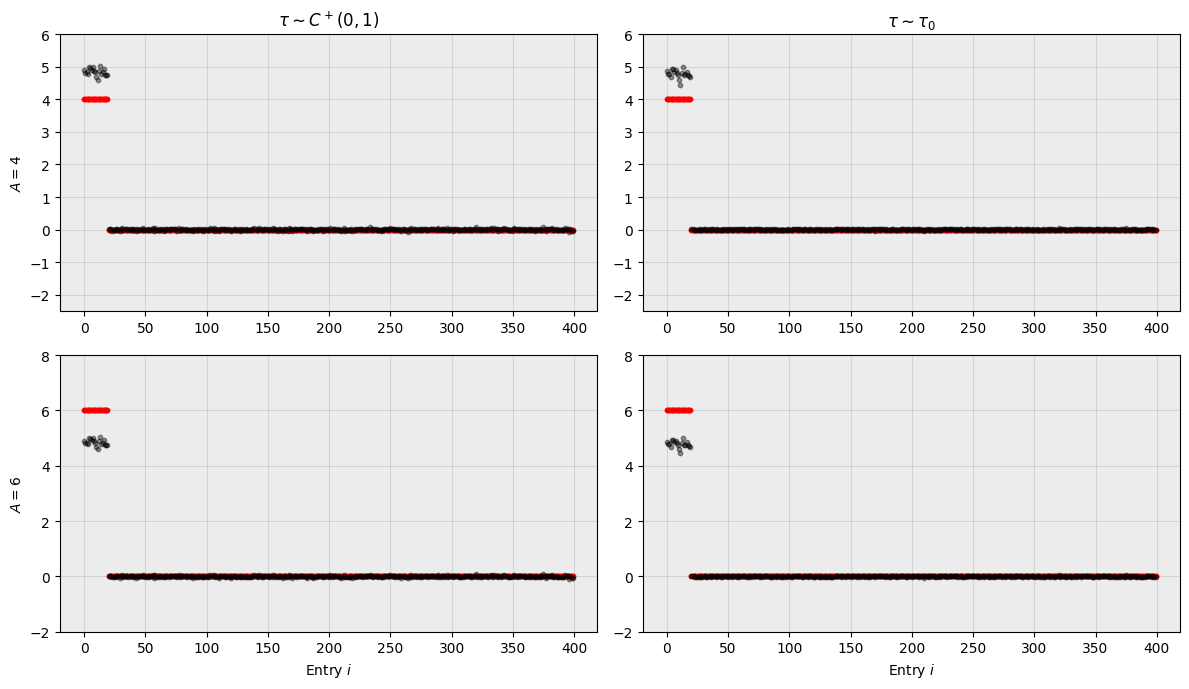

In [7]:
def plot_posterior_betas(beta_star, estimated_betas, ax):
    ax.scatter(range(D), beta_star, color='red', s=10) # plot actual betas
    ax.scatter(range(D), estimated_betas, color='black', s=10, alpha=0.4) # plot estimated betas
    # ax.scatter(range(len(y[i])), y[i], s=10, alpha=0.2, color='grey', marker='+') # plot y values


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax4.set_ylim([-2, 8]) 
ax3.set_ylim([-2, 8])
ax2.set_ylim([-2.5, 6]) 
ax1.set_ylim([-2.5, 6])

beta_star_4 = np.zeros(n)
beta_star_4[range(20)] = 4
beta_star_6 = np.zeros(n)
beta_star_6[range(20)] = 6
plot_posterior_betas(beta_star_4, hc_mean_betas[4], ax1)
plot_posterior_betas(beta_star_4, t0_mean_betas[4], ax2)
plot_posterior_betas(beta_star_6, hc_mean_betas[6], ax3)
plot_posterior_betas(beta_star_6, t0_mean_betas[6], ax4)

# add labels to graph
ax1.set_title(r'$\tau \sim C^+(0, 1)$')
ax2.set_title(r'$\tau \sim \tau_0$')
ax1.set(ylabel=r'$A=4$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')


(0.0, 0.3)

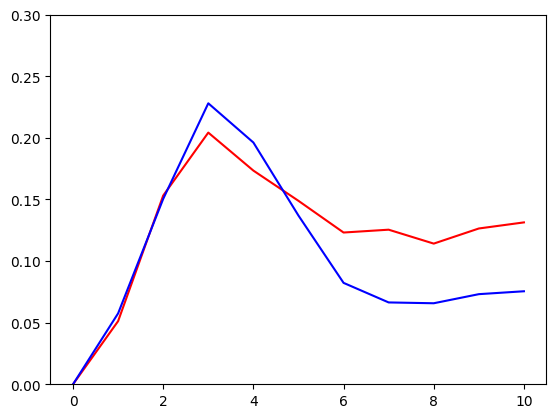

In [8]:
plt.plot(range(len(hc_mean_mse_values)), hc_mean_mse_values, "r")
plt.plot(range(len(t0_mean_mse_values)), t0_mean_mse_values, "b")
ax = plt.gca()
ax.set_ylim([0, 0.3])

<Axes: ylabel='Density'>

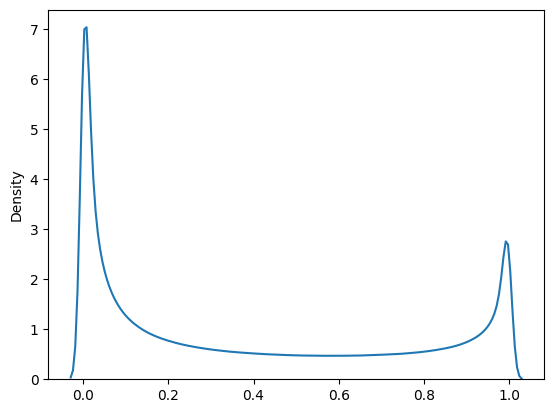

In [9]:
all_kappas = np.ndarray.flatten(np.array(all_kappas))
sns.kdeplot(all_kappas, legend=None)